In [1]:
import os
import sys
sys.path.append('/home/ubuntu/tools/python-genomics')
import Scanpyplus
import scanpy as sc
import pandas as pd

In [2]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80,dpi_save=100,color_map='PuRd')
sc.logging.print_version_and_date()

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
plt.show()
matplotlib.rcParams.update({'figure.figsize': (8,8)})

Running Scanpy 1.8.2, on 2021-12-14 15:53.


# Download example data from 10X Genomics

In [3]:
!wget http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz

--2021-12-14 15:53:42--  http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz [following]
--2021-12-14 15:53:42--  https://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37558165 (36M) [application/x-tar]
Saving to: ‘pbmc8k_filtered_gene_bc_matrices.tar.gz.1’

pbmc8k_filtered_gen 100%[===================>]  35.82M  78.9MB/s    in 0.5s    

2021-12-14 15:53:43 (78.9 MB/s) - ‘pbmc8k_filtered_gene_bc_matrices.tar.g

In [4]:
!tar xfz pbmc8k_filtered_gene_bc_matrices.tar.gz

In [5]:
adata=sc.read_10x_mtx('filtered_gene_bc_matrices/GRCh38/',cache=True)

... writing an h5ad cache file to speedup reading next time


In [6]:
adata

AnnData object with n_obs × n_vars = 8381 × 33694
    var: 'gene_ids'

# Follow Scanpy's pbmc tutorial to process the data

[Scanpy's pbmc tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)

filtered out 15354 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)


/home/ubuntu/miniconda3/envs/flng/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:03:08)
computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:07)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


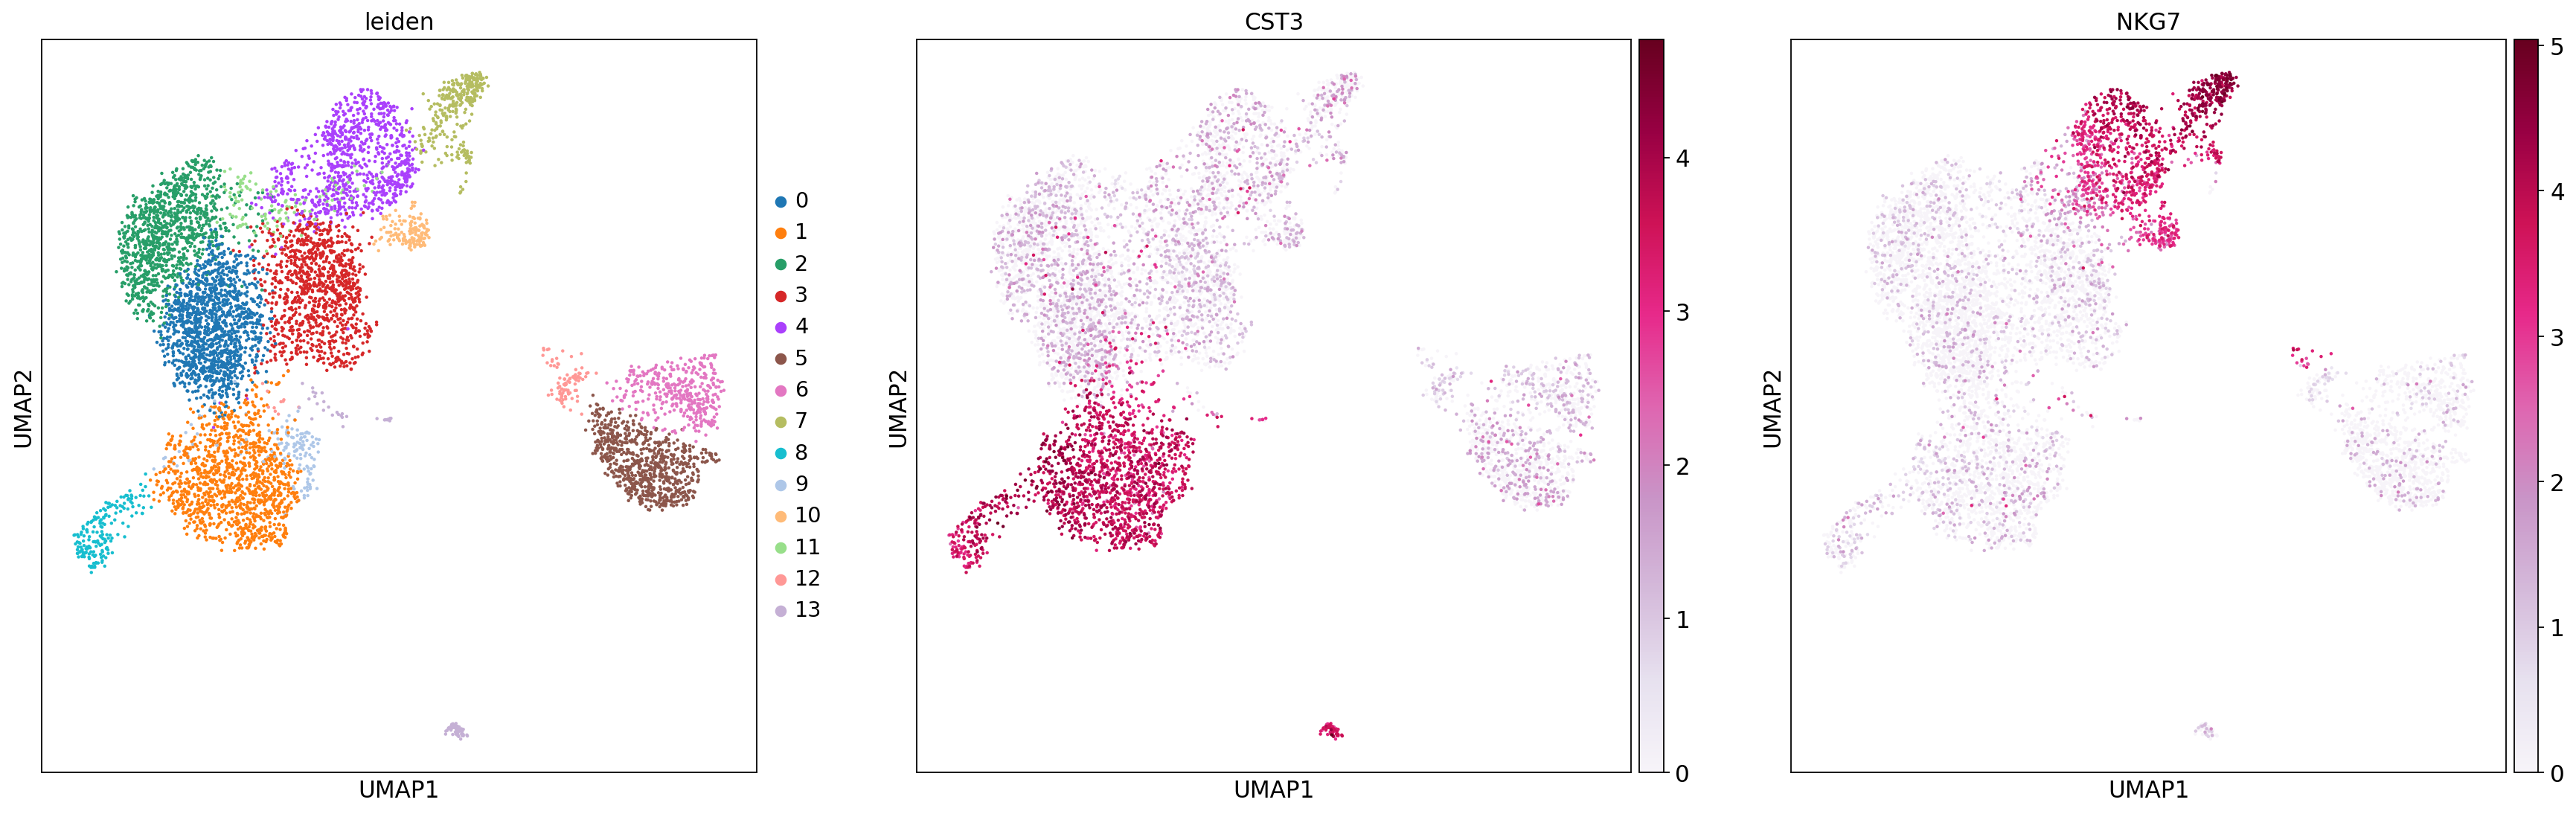

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

Retrieve raw (log-transformed) data

In [8]:
adata=Scanpyplus.GetRaw(adata)

# Manually annotated cell types based on marker genes

In [9]:
leiden2Celltype={'0':'CD4 T', #CD40LG
                 '1':'CD14 monocyte', #CD14
                 '2':'CD8 T', #CD8A
                 '3':'CD4 T', #CD40LG
                 '4':'NK', #NKG7
                 '5':'B', #MS4A1
                 '6':'B', #MS4A1
                 '7':'NK', #NKG7
                 '8':'CD16 monocyte', #FCGR3A
                 '9':'CD14 monocyte', #CD14
                 '10':'NK', #NKG7
                 '11':'CD8 T', #CD8A
                 '12':'B', #MS4A1
                 '13':'Megakaryocyte' #PPBP
                }

In [10]:
adata.obs['Celltype']=adata.obs['leiden'].replace(to_replace=leiden2Celltype)

/home/ubuntu/miniconda3/envs/flng/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Celltype' as categorical


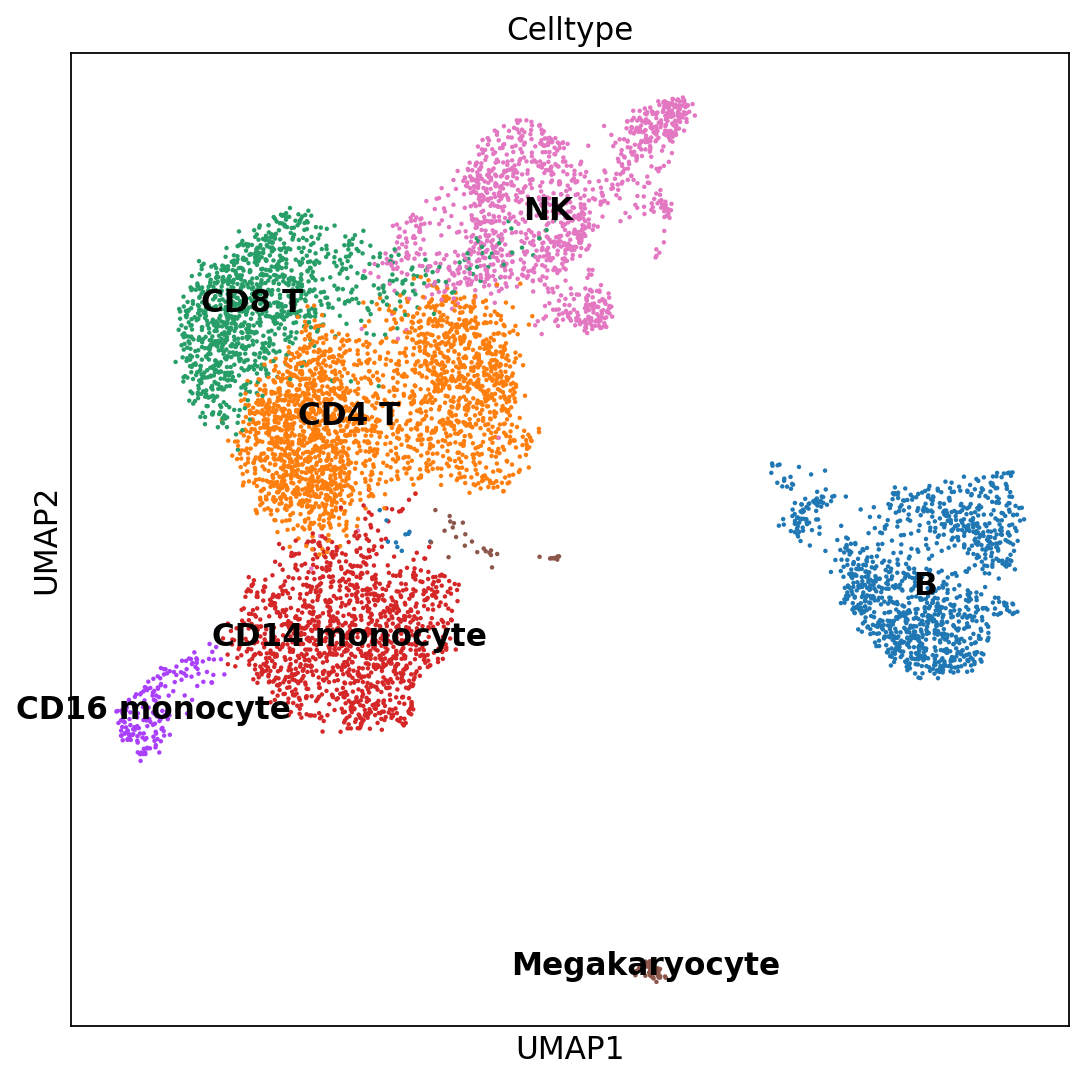

In [11]:
sc.pl.umap(adata, color=['Celltype'],legend_loc='on data')

# Subclustering

In [12]:
adata.obs['Celltype_R']=adata.obs['Celltype']
for i in adata.obs['Celltype'].unique():
    sc.tl.leiden(adata,resolution=2,restrict_to=('Celltype_R',[i]),key_added='Celltype_R')

running Leiden clustering
    finished: found 24 clusters and added
    'Celltype_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 44 clusters and added
    'Celltype_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 63 clusters and added
    'Celltype_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 77 clusters and added
    'Celltype_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 99 clusters and added
    'Celltype_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 111 clusters and added
    'Celltype_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 122 clusters and added
    'Celltype_R', the cluster labels (adata.obs, categorical) (0:00:00)


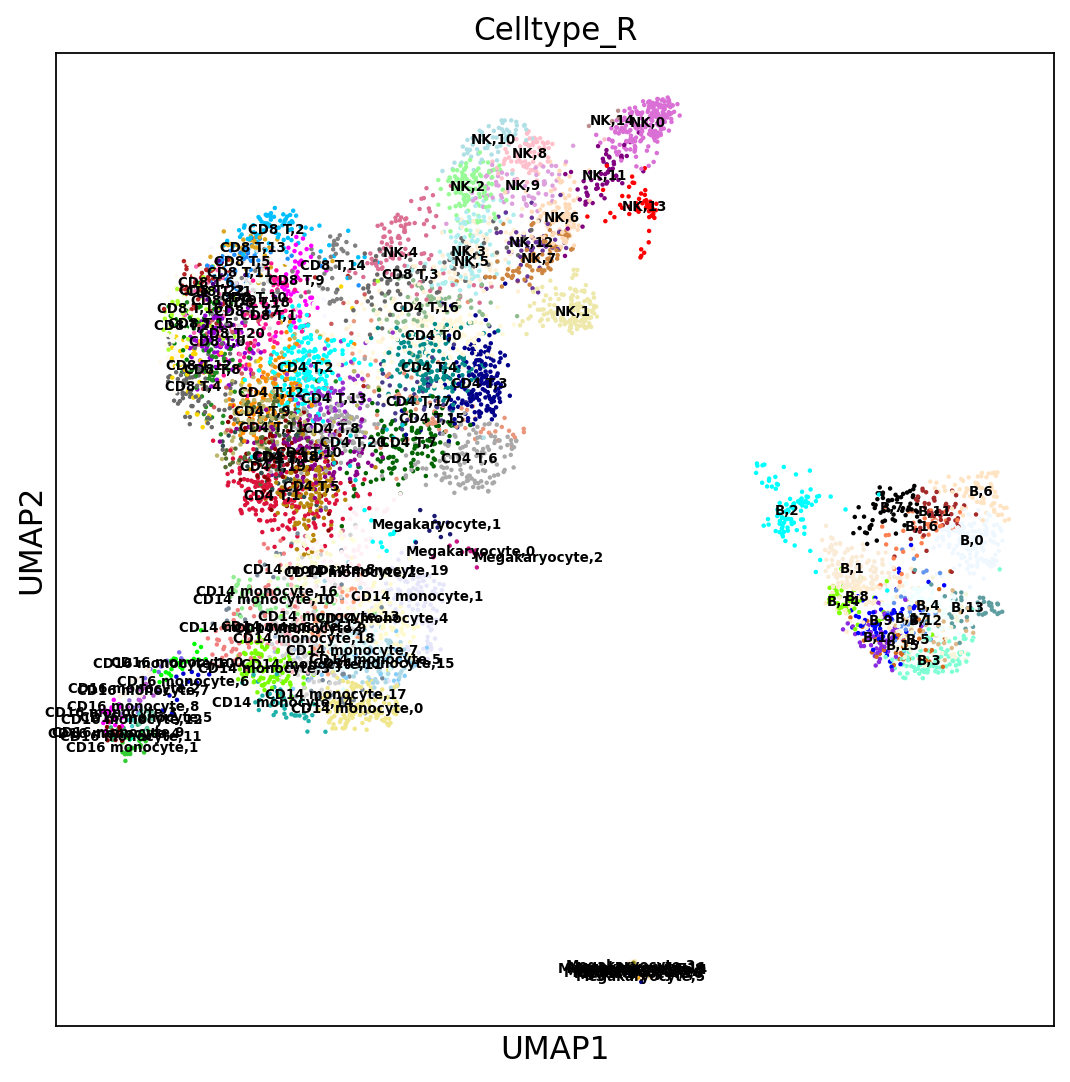

In [13]:
sc.pl.umap(adata, color='Celltype_R',palette=list(matplotlib.colors.CSS4_COLORS.values()),
          legend_loc='on data',legend_fontsize=6)

# DouCLing

Doublet Cluster Labeling is a process to visit each subcluster and try to find its two parents. Parent 1 comes from the initial annotation that is the bigger cluster the subcluster belongs; Parent 2 is another bigger cluster that explains the unique signatures of this subcluster that isn't shared with its sibling subclusters. 

Each subcluster's marker genes relative to its sibling subclusters were calculated. These marker genes were used to score all the cells. For cells that have higher scores than the average of the cells in this subcluster, they are regarded to be the "source" of the signature. If more than `fraction_threshold` of the source cells come from a big cluster, that big cluster is regarded as Parent 2.

In [14]:
DoubletReport=Scanpyplus.DouCLing(adata,'Celltype_R','Celltype',fraction_threshold=0.4)

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
computing score 'B,0_score'
    finished: added
    'B,0_score', score of gene set (adata.obs).
    547 total control genes are used. (0:00:00)
computing score 'B,1_score'
    finished: added
    'B,1_score', score of gene set (adata.obs).
    453 total control genes are used. (0:00:00)
computing score 'B,2_score'
    finished: added
    'B,2_score', score of gene set (adata.obs).
    154 total control genes are used. (0:00:00)
computing score 'B,3_score'
    finished: added
    'B,3_score', score of gene set (adata.obs).
    500 total control genes are used. (0:00:00)
computing score 'B,4_score'
    finished: added
    'B

Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
computing score 'CD4 T,0_score'


/home/ubuntu/miniconda3/envs/flng/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/ubuntu/miniconda3/envs/flng/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/ubuntu/miniconda3/envs/flng/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: Performance

    finished: added
    'CD4 T,0_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'CD4 T,1_score'
    finished: added
    'CD4 T,1_score', score of gene set (adata.obs).
    397 total control genes are used. (0:00:00)
computing score 'CD4 T,2_score'
    finished: added
    'CD4 T,2_score', score of gene set (adata.obs).
    51 total control genes are used. (0:00:00)
computing score 'CD4 T,3_score'
    finished: added
    'CD4 T,3_score', score of gene set (adata.obs).
    151 total control genes are used. (0:00:00)
computing score 'CD4 T,4_score'
    finished: added
    'CD4 T,4_score', score of gene set (adata.obs).
    252 total control genes are used. (0:00:00)
computing score 'CD4 T,5_score'
    finished: added
    'CD4 T,5_score', score of gene set (adata.obs).
    252 total control genes are used. (0:00:00)
computing score 'CD4 T,6_score'
    finished: added
    'CD4 T,6_score', score of gene set (adata.obs).
    248 total con

Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
computing score 'CD8 T,0_score'
    finished: added
    'CD8 T,0_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'CD8 T,1_score'
    finished: added
    'CD8 T,1_score', score of gene set (adata.obs).
    552 total control genes are used. (0:00:00)
computing score 'CD8 T,2_score'
    finished: added
    'CD8 T,2_score', score of gene set (adata.obs).
    450 total control genes are used. (0:00:00)
computing score 'CD8 T,3_score'
    finished: added
    'CD8 T,3_score', score of gene set (adata.obs).
    151 total control genes are used. (0:00:00)
computing score 'CD8 T

Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
computing score 'CD14 monocyte,0_score'
    finished: added
    'CD14 monocyte,0_score', score of gene set (adata.obs).
    403 total control genes are used. (0:00:00)
computing score 'CD14 monocyte,1_score'
    finished: added
    'CD14 monocyte,1_score', score of gene set (adata.obs).
    250 total control genes are used. (0:00:00)
computing score 'CD14 monocyte,2_score'
    finished: added
    'CD14 monocyte,2_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'CD14 monocyte,3_score'
    finished: added
    'CD14 monocyte,3_score', score of gene set (adata.obs).
    30

Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
computing score 'CD16 monocyte,0_score'
    finished: added
    'CD16 monocyte,0_score', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)
computing score 'CD16 monocyte,1_score'
    finished: added
    'CD16 monocyte,1_score', score of gene set (adata.obs).
    445 total control genes are used. (0:00:00)
computing score 'CD16 monocyte,2_score'
    finished: added
    'CD16 monocyte,2_score', score of gene set (adata.obs).
    251 total control genes are used. (0:00:00)
computing score 'CD16 monocyte,3_score'
    finished: added
    'CD16 monocyte,3_score', score of gene set (adata.obs).
    39

Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
computing score 'Megakaryocyte,0_score'
    finished: added
    'Megakaryocyte,0_score', score of gene set (adata.obs).
    650 total control genes are used. (0:00:00)
computing score 'Megakaryocyte,1_score'
    finished: added
    'Megakaryocyte,1_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)
computing score 'Megakaryocyte,2_score'
    finished: added
    'Megakaryocyte,2_score', score of gene set (adata.obs).
    646 total control genes are used. (0:00:00)
computing score 'Megakaryocyte,3_score'
    finished: added
    'Megakaryocyte,3_score', score of gene set (adata.obs).
    595

Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
computing score 'NK,0_score'
    finished: added
    'NK,0_score', score of gene set (adata.obs).
    399 total control genes are used. (0:00:00)
computing score 'NK,1_score'
    finished: added
    'NK,1_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'NK,2_score'
    finished: added
    'NK,2_score', score of gene set (adata.obs).
    250 total control genes are used. (0:00:00)
computing score 'NK,3_score'
    finished: added
    'NK,3_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'NK,4_score'
    finished: add

In [15]:
DoubletReport

,Parent1,Parent2,Parent1_count,Parent2_count,All_count,p_value,Is_doublet_cluster
"B,4",B,B,28,28,28,0.000000e+00,False
"CD4 T,4",CD4 T,CD4 T,52,52,52,0.000000e+00,False
"CD4 T,5",CD4 T,CD4 T,89,89,139,0.000000e+00,False
"CD14 monocyte,3",CD14 monocyte,CD14 monocyte,62,62,90,0.000000e+00,False
"CD14 monocyte,11",CD14 monocyte,CD14 monocyte,16,16,16,0.000000e+00,False
...,...,...,...,...,...,...,...
"CD4 T,20",CD4 T,CD14 monocyte,26,949,992,0.000000e+00,True
"CD14 monocyte,19",CD14 monocyte,Megakaryocyte,3,14,17,1.865462e-27,True
"Megakaryocyte,11",Megakaryocyte,Megakaryocyte,1,1,1,0.000000e+00,False
"Megakaryocyte,8",Megakaryocyte,Megakaryocyte,1,1,1,0.000000e+00,False


In this report, the rows with different Parent1 and Parent2 represent potential doublet clusters. The counts are the counts of "source" cells defined earlier. Based on empirical results, a suggestion is given in the last column

In [16]:
DoubletReport.to_csv('temp.csv') #save output to a csv file

You can also visualize doublet subclusters

In [17]:
adata.obs['DouCLing']=pd.Categorical(adata.obs['Celltype_R'].isin(DoubletReport.loc[DoubletReport.Is_doublet_cluster,
                                                                     :].index.tolist()))

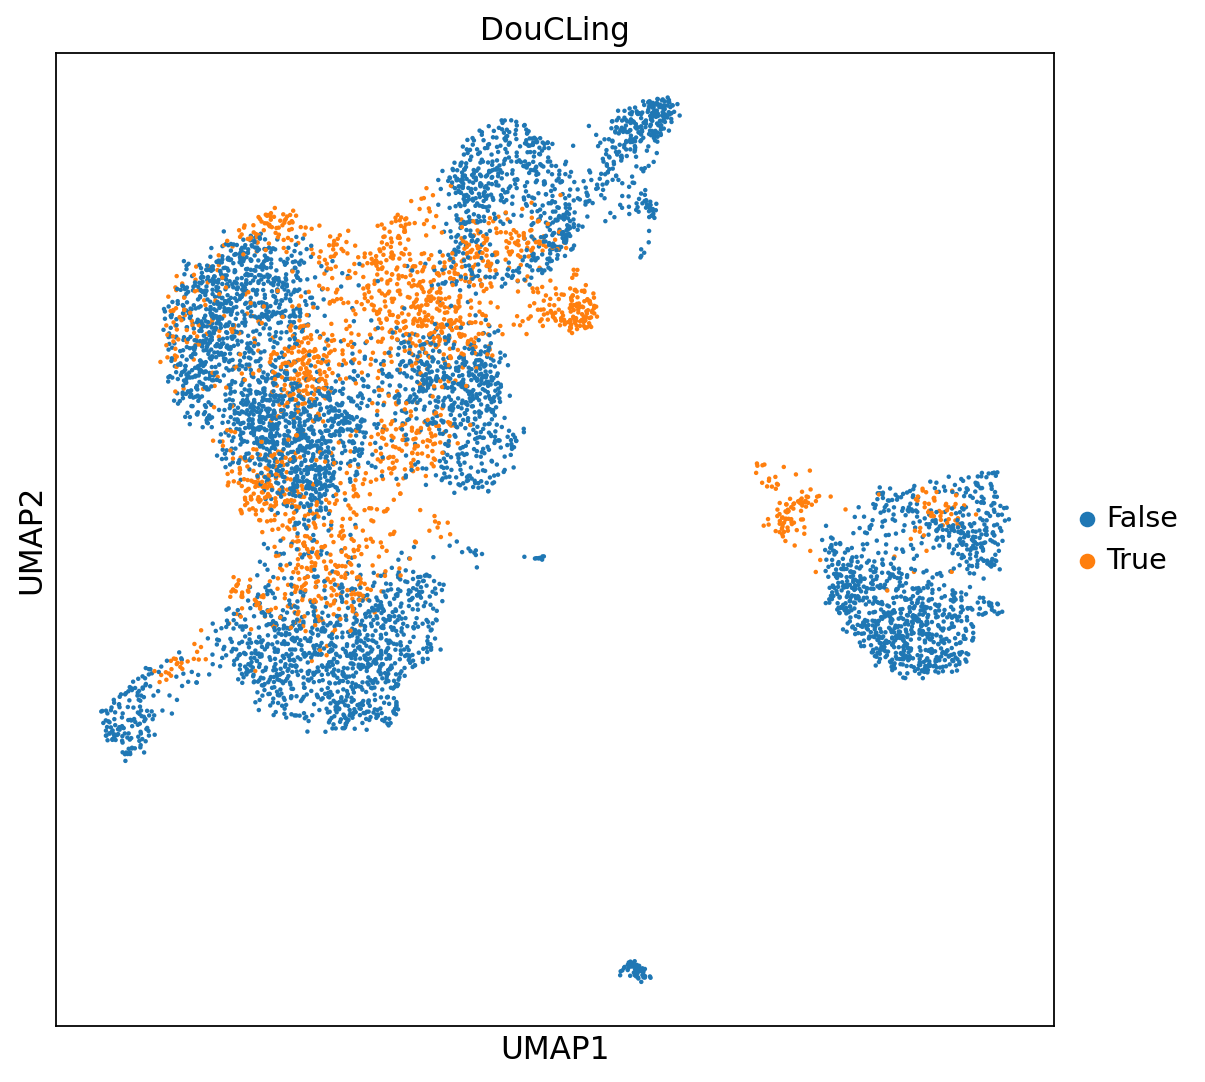

In [18]:
sc.pl.umap(adata, color='DouCLing')

Please note that cycling cell clusters may confuse the algorithm. You can provide a list of cell cycle genes to let DouCLing ignore them by specifying `rm_genes=Cell_cycle_genes`